# PRÁCTICA 5 - VÍCTOR CHOZA MERINO - ADRIÁN TURIEL CHARRO

### Cargando datos

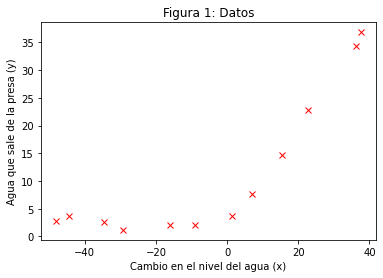

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import scipy.io

data = loadmat ('ex5data1.mat')

X = data['X']         # datos de entrenamiento
y = data['y']         # (12, 1)
Xtest = data['Xtest'] # ejemplos de validación
ytest = data['ytest'] # (21, 1)
Xval = data['Xval']   # ejemplos de prueba
yval = data['yval']   # (21, 1)

X1s = np.hstack([np.ones([len(X), 1]), X])
X1sval = np.hstack([np.ones([len(Xval), 1]), Xval])

plt.xlabel('Cambio en el nivel del agua (x)')
plt.ylabel('Agua que sale de la presa (y)')
plt.title('Figura 1: Datos')
plt.plot(X, y, 'rx')

### Funciones útiles

##### costeYGradiente

In [2]:
def costeYGradiente(theta, X, y, lambdaa):
    m = len(X)
    
    theta = theta.reshape(-1, y.shape[1])
    grad = (1/m) * (X.T @ (X@theta - y)) + (lambdaa/m) * theta
    #Le quitamos el término de regularización a j=0
    grad[0] = grad[0] - (lambdaa/m) * theta[0,:] 
    
    coste = (1/(2*m)) * sum((X@theta-y)**2) + (lambdaa/(2*m)) * sum(theta[1:]**2)
    
    return (coste[0], grad.flatten())
    

##### trainReg

In [3]:
def trainReg(X, y, lambdaa):

    m = len(X) #Número de casos de entrenamiento
    n = np.shape(X)[1]
    
    Thetas = np.ones(n)
    
    result = minimize(fun=costeYGradiente, x0=Thetas, args=(X, y, lambdaa),
                       method='CG',
                       jac=True,
                       options={'maxiter':70})
    
    return result.x

##### poly1sNormalizarMatriz

In [4]:
def poly1sNormalizarMatriz(X, p, mus, sigmas):
    X = X.reshape(X.size, 1)
    
    X_poly = np.zeros((np.shape(X)[0], p))
    
    for i in range(p):                   
        X_poly[:,i] = np.ravel(X**(i+1)) # Crea las columnas elevadas a i+1
        
    mus = np.mean(X_poly, axis=0) if (mus is None) else mus
    sigmas = np.std(X_poly, axis=0) if (sigmas is None) else sigmas
    
    X_poly_norm = (X_poly-mus)/sigmas # Normaliza los valores con mus y sigmas
    X1s_poly_norm = np.insert(X_poly_norm, 0, 1, axis=1) # Añade columna de unos
    
    return mus, sigmas, X1s_poly_norm 

### Regresión lineal regularizada

Coste:  303.9931922202643
Gradiente:  [-15.30301567 598.25074417]
Optimizado:  [13.08790734  0.36777925]


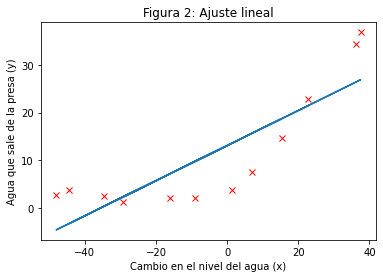

In [5]:
coste, gradiente = costeYGradiente(np.array([[1], [1]]), X1s, y, 1)

print('Coste: ', coste)
print('Gradiente: ', gradiente)

theta = trainReg(X1s, y, 0)

print('Optimizado: ', theta)

plt.xlabel('Cambio en el nivel del agua (x)')
plt.ylabel('Agua que sale de la presa (y)')
plt.title('Figura 2: Ajuste lineal')
plt.plot(X, y, 'rx')
plt.plot(X, np.dot(np.insert(X, 0, 1, axis=1), theta))

### Curvas de aprendizaje

In [6]:
def curvaAprendizaje(X, y, Xval, yval, lambdaa):
    m = len(X) #Número de casos de entrenamiento
    
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for i in range(1, m+1):
        theta = trainReg(X[0:i], y[0:i], lambdaa)
        
        #Para calcular los errores se llama a la función com lambda = 0
        error_train[i-1] = costeYGradiente(theta,X[0:i], y[0:i], 0)[0]
        error_val[i-1] = costeYGradiente(theta, Xval, yval, 0)[0]
        
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error

1			0.000000	169.870708
2			0.000000	110.300366
3			3.286595	45.010231
4			2.842678	48.368921
5			13.154049	35.865165
6			19.443963	33.829962
7			20.098522	31.970986
8			18.172859	30.862446
9			22.609405	31.135997
10			23.261462	28.936207
11			24.317250	29.551432
12			22.373906	29.433813


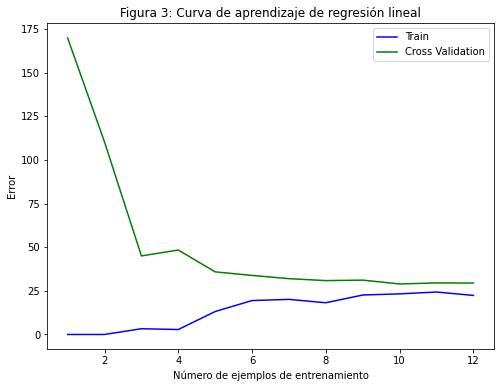

In [7]:
m = len(X)

#Para calcular los errores se llama a la función com lambda = 0
error_train, error_val = curvaAprendizaje(X1s, y, X1sval, yval, 0)

print('# Training Examples\tTrain Error\tCross Validation Error\n')
for i in range(m):
    print('{}\t\t\t{:f}\t{:f}'.format(i+1, float(error_train[i]), float(error_val[i])))

plt.figure(figsize=(8, 6))
plt.xlabel('Número de ejemplos de entrenamiento')
plt.ylabel('Error')
plt.title('Figura 3: Curva de aprendizaje de regresión lineal')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

### Regresión polinomial

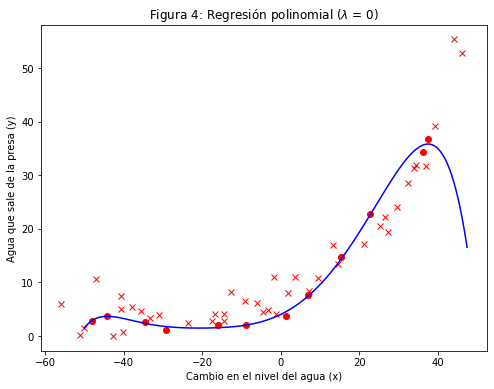

In [8]:
p = 8

mus, sigmas, X1s_poly_norm = poly1sNormalizarMatriz(X, p, None, None) 

theta = trainReg(X1s_poly_norm, y, 0)

plt.figure(figsize=(8, 6))
plt.title('Figura 4: Regresión polinomial ($\lambda$ = 0)')
plt.scatter(X.flatten(), y.flatten(), c='r') 
plt.plot(Xtest, ytest, 'rx')   
plt.plot(Xval, yval, 'rx')    
plt.xlabel('Cambio en el nivel del agua (x)')
plt.ylabel('Agua que sale de la presa (y)')

#Pinta la línea de la función de las thetas
x_min, x_max = min(X.flatten()) - 2, max(X.flatten()) + 10
x_arr = np.arange(x_min, x_max, 0.05)
y_arr = []
for x1 in x_arr:
    x1 = poly1sNormalizarMatriz(x1, p, mus, sigmas)[2]
    y_arr.append(x1 @ theta) # Hipótesis
plt.plot(x_arr, y_arr, c='b')
plt.show()

# Training Examples	Train Error	Cross Validation Error

1			0.000000	99.523441
2			0.000000	99.488128
3			0.000000	58.435620
4			0.000000	56.701379
5			0.000000	6.660889
6			0.000001	10.673120
7			0.000001	27.889675
8			0.075313	5.536340
9			0.192504	7.274097
10			0.039796	23.847661
11			0.039060	24.218775
12			0.178316	31.114984


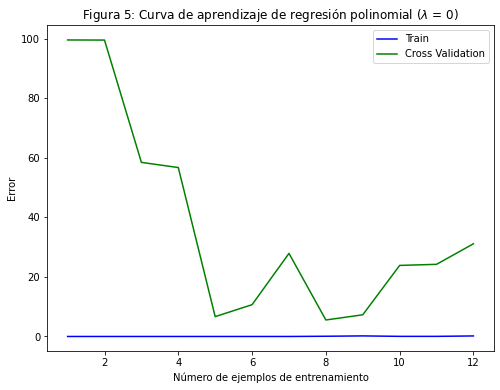

In [9]:
p = 8

mus, sigmas, X1s_poly_norm = poly1sNormalizarMatriz(X, p, None, None) 
Xval_poly_norm = poly1sNormalizarMatriz(Xval, p, mus, sigmas)[2]

#Para calcular los errores se llama a la función com lambda = 0
error_train, error_val = curvaAprendizaje(X1s_poly_norm, y, Xval_poly_norm, yval, 0)

print('# Training Examples\tTrain Error\tCross Validation Error\n')
for i in range(len(X)):
    print('{}\t\t\t{:f}\t{:f}'.format(i+1, float(error_train[i]), float(error_val[i])))

plt.figure(figsize=(8, 6))
plt.xlabel('Número de ejemplos de entrenamiento')
plt.ylabel('Error')
plt.title('Figura 5: Curva de aprendizaje de regresión polinomial ($\lambda$ = 0)')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

### Selección del parámetro λ

In [10]:
def curvaValidacion(X, y, Xval, yval, lambdaa_set):
    m = len(lambdaa_set) #Número de casos de entrenamiento
    
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for j, lambda_i in enumerate(lambda_set):        
        theta = trainReg(X, y, lambda_i)
        
        #Para calcular los errores se llama a la función com lambda = 0
        error_train[j] = costeYGradiente(theta,X, y, 0)[0]
        error_val[j] = costeYGradiente(theta, Xval, yval, 0)[0]
        
    return error_train, error_val

lambda		Train Error	Validation Error
0		0.178316	31.114984
0.001		0.162766	20.806608
0.003		0.186321	23.273536
0.01		0.221940	18.006349
0.03		0.275362	13.218117
0.1		0.438686	7.926146
0.3		0.868163	4.760818
1.0		1.958694	4.263370
3.0		4.525101	3.832171
10.0		14.825783	8.889693


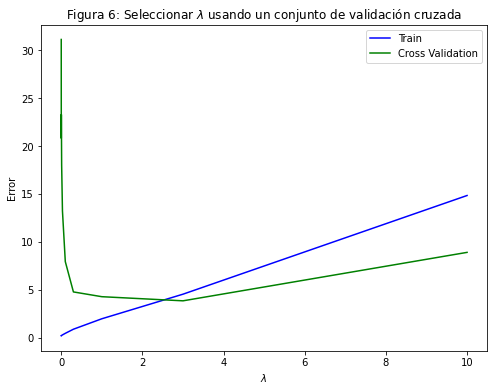

In [11]:
p = 8

lambda_set = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

mus, sigmas, X1s_poly_norm = poly1sNormalizarMatriz(X, p, None, None) 
Xval_poly_norm = poly1sNormalizarMatriz(Xval, p, mus, sigmas)[2]
error_train, error_val = curvaValidacion(
    X1s_poly_norm, y, Xval_poly_norm, yval, lambda_set) #Introducimos las lambdas

print('lambda\t\tTrain Error\tValidation Error')
for i, lambda_set_i in enumerate(lambda_set):
    print('{}\t\t{:f}\t{:f}'.format(lambda_set_i,
                                    float(error_train[i]), float(error_val[i])))

plt.figure(figsize=(8, 6))
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.title('Figura 6: Seleccionar $\lambda$ usando un conjunto de validación cruzada')
plt.plot(lambda_set, error_train, 'b', label='Train')
plt.plot(lambda_set, error_val, 'g', label='Cross Validation')
plt.legend()

In [12]:
lambda_optimo = 3
Xtest_poly_norm = poly1sNormalizarMatriz(Xtest, p, mus, sigmas)[2]

theta = trainReg(X1s_poly_norm, y, lambda_optimo)

#Para calcular los errores se llama a la función com lambda = 0
error_test = costeYGradiente(theta, Xtest_poly_norm, ytest, 0)[0] 
print("Error de prueba para la mejor lambda: {0:.4f}".format(error_test))

Error de prueba para la mejor lambda: 3.5720
